In [56]:
import requests
from bs4 import BeautifulSoup
import time
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import streamlit as st

In [3]:
TOTAL_PAGE = 5
BASE_URL = "https://www.pakwheels.com/used-cars/search/-/featured_1/"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

In [ ]:
def scrape_pages(num_pages=TOTAL_PAGE):
    results = []
    for page in range(1, num_pages + 1):
        url = BASE_URL + f"?page={page}"
        resp = requests.get(url, headers=HEADERS)
        if resp.status_code != 200:
            print(f"Failed to fetch page {page}, status: {resp.status_code}")
            continue
        
        soup = BeautifulSoup(resp.text, "html.parser")
     
        # break
       
        cards = soup.select('li.classified-listing')
      
        for card in cards:
            json_block = card.select_one('script[type="application/ld+json"]')
            if not json_block:
                continue
             
            data = json.loads(json_block.get_text(strip=True))
            # print(data)
           
            item = {
                "brand": data.get("brand", {}).get("name"),
                "model_year": data.get("modelDate"),
                "description": data.get("description"),
                "fuel": data.get("fuelType"),
                "transmission": data.get("vehicleTransmission"),
                "engine": data.get("vehicleEngine", {}).get("engineDisplacement"),
                "mileage": data.get("mileageFromOdometer"),
                "price": data.get("offers", {}).get("price"),
                "currency": data.get("offers", {}).get("priceCurrency"),
                "url": data.get("offers", {}).get("url"),
                "image": data.get("image")
            }
            results.append(item)

        time.sleep(1)  # polite delay

    return results

In [6]:
def save_to_csv(data, filename="pakwheels_listings.csv"):
    keys = data[0].keys()
    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=keys)
        writer.writeheader()
        writer.writerows(data)

In [28]:
scraped = scrape_pages(5)
print(scraped)
print(f"Scraped {len(scraped)} listings")
save_to_csv(scraped)

[{'brand': 'Toyota', 'model_year': 2021, 'description': 'Toyota Aqua 2021 for sale in Islamabad', 'fuel': 'Hybrid', 'transmission': 'Automatic', 'engine': '1500cc', 'mileage': '22,000 km', 'price': 3799000, 'currency': 'PKR', 'url': 'https://www.pakwheels.com/used-cars/toyota-aqua-2021-for-sale-in-islamabad-8158030', 'image': 'https://cache3.pakwheels.com/ad_pictures/1283/toyota-aqua-z-4-2021-128353575.jpg'}, {'brand': 'Toyota', 'model_year': 2021, 'description': 'Toyota Yaris Hatchback 2021 for sale in Islamabad', 'fuel': 'Petrol', 'transmission': 'Automatic', 'engine': '1000cc', 'mileage': '85,000 km', 'price': 4399000, 'currency': 'PKR', 'url': 'https://www.pakwheels.com/used-cars/toyota-yaris-hatchback-2021-for-sale-in-islamabad-10314129', 'image': 'https://cache1.pakwheels.com/ad_pictures/1251/toyota-yaris-hatchback-g-1-0-2021-125157339.jpg'}, {'brand': 'Daihatsu', 'model_year': 2022, 'description': 'Daihatsu Move 2022 for sale in Islamabad', 'fuel': 'Petrol', 'transmission': 'Aut

In [30]:
df = pd.read_csv('./pakwheels_listings.csv')

In [32]:
df.head()

,brand,model_year,description,fuel,transmission,engine,mileage,price,currency,url,image
0,Toyota,2021.0,Toyota Aqua 2021 for sale in Islamabad,Hybrid,Automatic,1500cc,"22,000 km",3799000.0,PKR,https://www.pakwheels.com/used-cars/toyota-aqu...,https://cache3.pakwheels.com/ad_pictures/1283/...
1,Toyota,2021.0,Toyota Yaris Hatchback 2021 for sale in Islamabad,Petrol,Automatic,1000cc,"85,000 km",4399000.0,PKR,https://www.pakwheels.com/used-cars/toyota-yar...,https://cache1.pakwheels.com/ad_pictures/1251/...
2,Daihatsu,2022.0,Daihatsu Move 2022 for sale in Islamabad,Petrol,Automatic,660cc,"33,000 km",3699000.0,PKR,https://www.pakwheels.com/used-cars/daihatsu-m...,https://cache1.pakwheels.com/ad_pictures/1277/...
3,Suzuki,2019.0,Suzuki Swift 2019 for sale in Peshawar,Petrol,Automatic,1300cc,"200,000 km",2796000.0,PKR,https://www.pakwheels.com/used-cars/suzuki-swi...,https://cache3.pakwheels.com/ad_pictures/1324/...
4,Toyota,2016.0,Toyota Corolla 2016 for sale in Rawalpindi,Petrol,Automatic,1600cc,"113,500 km",4350000.0,PKR,https://www.pakwheels.com/used-cars/toyota-cor...,https://cache2.pakwheels.com/ad_pictures/1277/...


## Data Cleaning

In [33]:
df["price"] = pd.to_numeric(df["price"], errors="coerce")

In [34]:
df["engine_cc"] = (
    df["engine"]
    .str.extract(r"(\d+)")
    .astype(float)
)

In [35]:
df["mileage_km"] = (
    df["mileage"]
    .str.replace(",", "", regex=True)
    .str.extract(r"(\d+)")
    .astype(float)
)

In [36]:
df["city"] = df["description"].str.extract(r"in\s+([A-Za-z ]+)$")


In [37]:
df.head()

,brand,model_year,description,fuel,transmission,engine,mileage,price,currency,url,image,engine_cc,mileage_km,city
0,Toyota,2021.0,Toyota Aqua 2021 for sale in Islamabad,Hybrid,Automatic,1500cc,"22,000 km",3799000.0,PKR,https://www.pakwheels.com/used-cars/toyota-aqu...,https://cache3.pakwheels.com/ad_pictures/1283/...,1500.0,22000.0,Islamabad
1,Toyota,2021.0,Toyota Yaris Hatchback 2021 for sale in Islamabad,Petrol,Automatic,1000cc,"85,000 km",4399000.0,PKR,https://www.pakwheels.com/used-cars/toyota-yar...,https://cache1.pakwheels.com/ad_pictures/1251/...,1000.0,85000.0,Islamabad
2,Daihatsu,2022.0,Daihatsu Move 2022 for sale in Islamabad,Petrol,Automatic,660cc,"33,000 km",3699000.0,PKR,https://www.pakwheels.com/used-cars/daihatsu-m...,https://cache1.pakwheels.com/ad_pictures/1277/...,660.0,33000.0,Islamabad
3,Suzuki,2019.0,Suzuki Swift 2019 for sale in Peshawar,Petrol,Automatic,1300cc,"200,000 km",2796000.0,PKR,https://www.pakwheels.com/used-cars/suzuki-swi...,https://cache3.pakwheels.com/ad_pictures/1324/...,1300.0,200000.0,Peshawar
4,Toyota,2016.0,Toyota Corolla 2016 for sale in Rawalpindi,Petrol,Automatic,1600cc,"113,500 km",4350000.0,PKR,https://www.pakwheels.com/used-cars/toyota-cor...,https://cache2.pakwheels.com/ad_pictures/1277/...,1600.0,113500.0,Rawalpindi


## Analysis

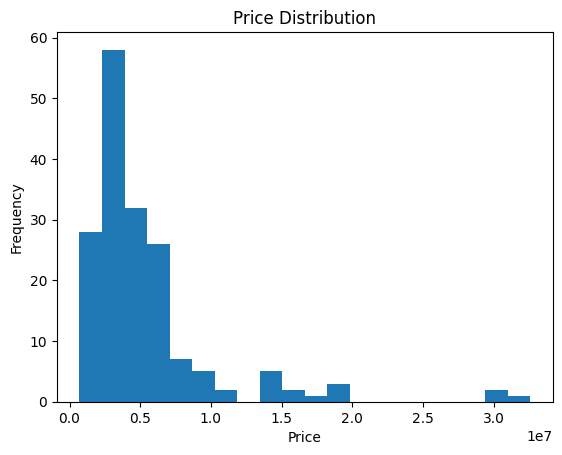

In [53]:
# Price distribution
plt.figure()
df["price"].dropna().plot.hist(bins=20)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

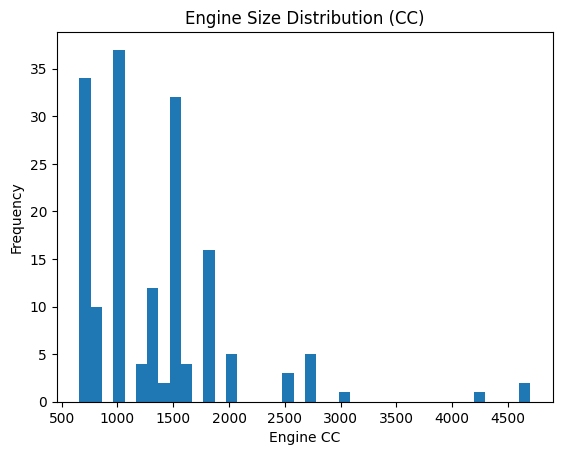

In [47]:
# Engine size distribution
plt.figure()
df["engine_cc"].dropna().plot.hist(bins=40)
plt.title("Engine Size Distribution (CC)")
plt.xlabel("Engine CC")
plt.ylabel("Frequency")
plt.show()

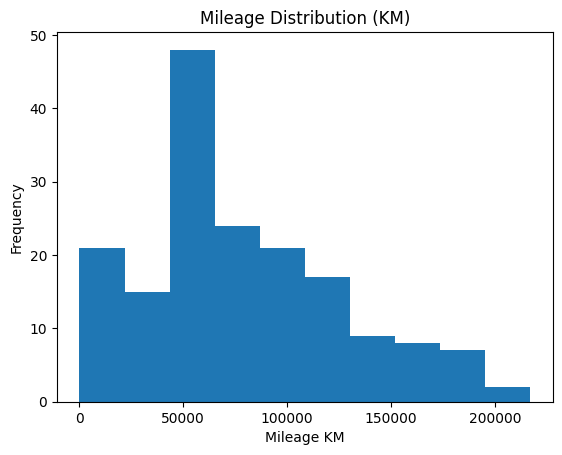

In [48]:
# Mileage distribution
plt.figure()
df["mileage_km"].dropna().plot.hist(bins=10)
plt.title("Mileage Distribution (KM)")
plt.xlabel("Mileage KM")
plt.ylabel("Frequency")
plt.show()

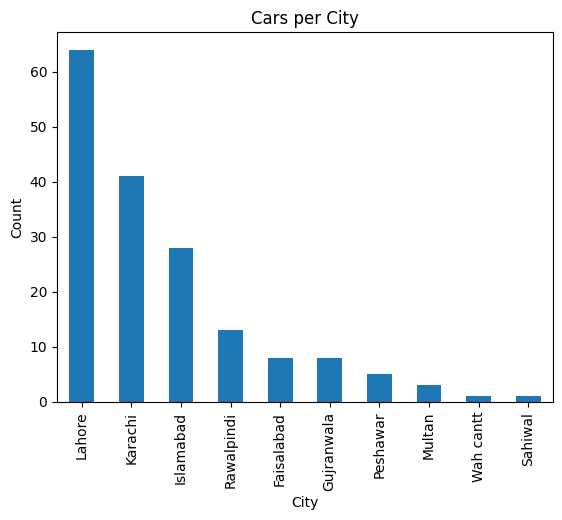

In [42]:
# City-wise concentration
plt.figure()
df["city"].value_counts().plot.bar()
plt.title("Cars per City")
plt.xlabel("City")
plt.ylabel("Count")
plt.show()

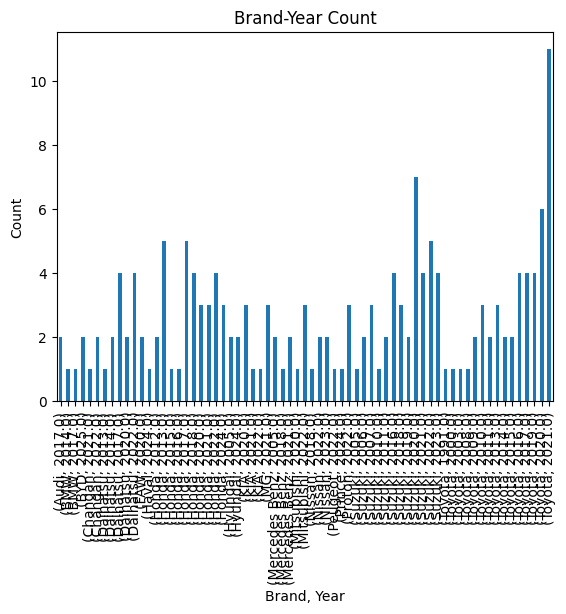

In [43]:
# Brand–Year aging pattern
plt.figure()
df.groupby(["brand", "model_year"]).size().plot.bar()
plt.title("Brand-Year Count")
plt.xlabel("Brand, Year")
plt.ylabel("Count")
plt.show()

## Best Car

In [55]:

df_sorted = df.sort_values(
    by=["model_year", "mileage_km", "price"],
    ascending=[False, True, True]
)

best_car = df_sorted.iloc[0]
print(best_car)


brand                                                         BYD
model_year                                                 2025.0
description                    BYD Atto 3 2025 for sale in Lahore
fuel                                                     Electric
transmission                                            Automatic
engine                                                         cc
mileage                                                  1,000 km
price                                                   8900000.0
currency                                                      PKR
url             https://www.pakwheels.com/used-cars/byd-atto-3...
image           https://cache3.pakwheels.com/ad_pictures/1320/...
engine_cc                                                     NaN
mileage_km                                                 1000.0
city                                                       Lahore
Name: 14, dtype: object
